Import all essential libraries for data manipulation, visualization, feature scaling, clustering, and dimensionality reduction. These libraries provide the tools needed for unsupervised learning and exploratory data analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Load the processed diabetes dataset from CSV into a pandas DataFrame for analysis. This dataset contains cleaned and engineered features ready for clustering and unsupervised exploration.

In [3]:
df = pd.read_csv("processed_diabetes_data.csv")

Select a subset of relevant clinical and healthcare utilization features for clustering. These features are chosen because they capture key aspects of patient profiles that may influence clustering outcomes. A new DataFrame is created for focused analysis.

In [4]:
# Select a meaningful subset of features for clustering
# These features describe the patient's clinical characteristics and healthcare utilization that are relevant for clustering patients with similar profiles.
cluster_features = [
    'age',
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_diagnoses',
    'number_inpatient',
    'number_emergency',
    'number_outpatient',
]

# Create a new dataframe for clustering
df_cluster = df[cluster_features].copy()


Scale the selected features using StandardScaler to ensure all features contribute equally to distance-based clustering algorithms like K-Means. Feature scaling is critical for meaningful cluster formation.

In [5]:
# Scale the features
# This is CRITICAL for distance-based algorithms like K-Means
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

Use the Elbow Method to determine the optimal number of clusters for K-Means by plotting within-cluster sum of squares (WCSS) for different values of k. This helps identify the point where adding more clusters does not significantly improve model fit.

Optimal number of clusters (Elbow): 4


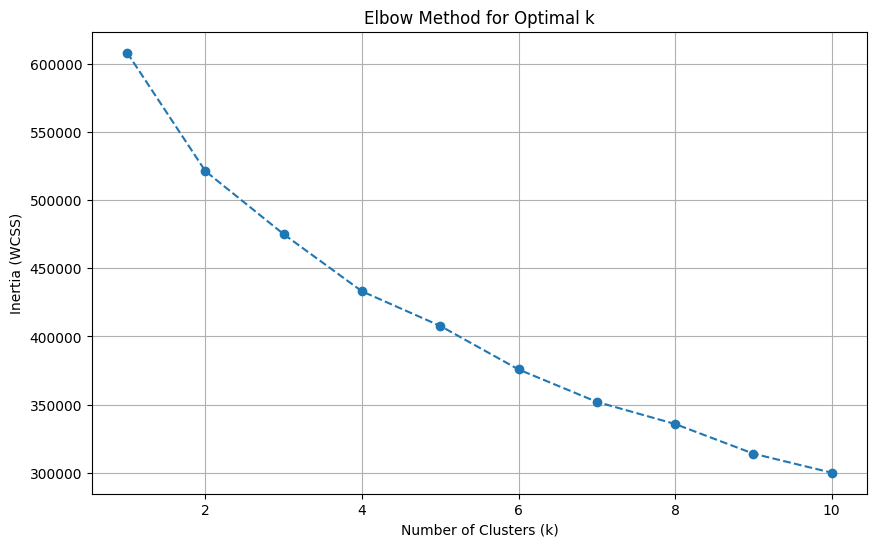

In [ ]:
# Use the Elbow Method to find a good number of clusters
wcss = [] # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_cluster_scaled)
    wcss.append(kmeans.inertia_)

# Use KneeLocator from kneed to automatically find the "elbow" point in the WCSS curve
from kneed import KneeLocator
knee = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
print("Optimal number of clusters (Elbow):", knee.knee)


# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
# plt.savefig("kmeans_elbow_plot.png")
plt.show()

Apply K-Means clustering with the chosen number of clusters and assign cluster labels to each patient in the dataset. This step segments patients into distinct profiles based on their clinical and utilization characteristics.

In [7]:
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(df_cluster_scaled)

# Add the cluster labels back to your original dataframe
df['patient_profile'] = cluster_labels

Reduce the scaled feature space to two principal components using PCA for visualization. The resulting scatter plot allows for intuitive inspection of cluster separation and structure in two dimensions.

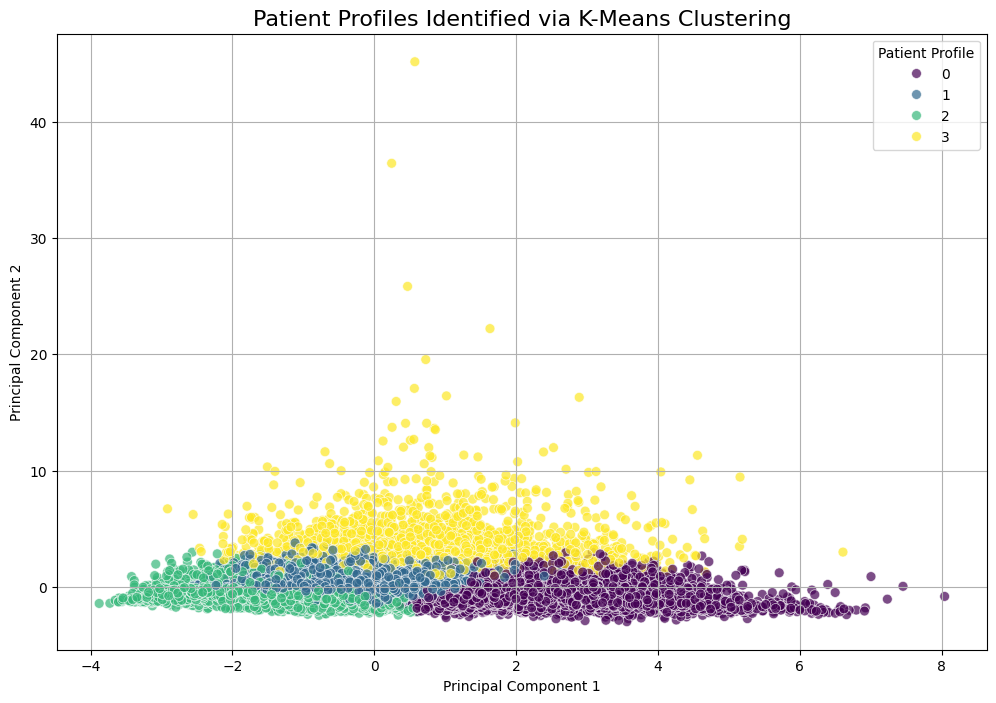

In [ ]:
# Use PCA to reduce data to 2 dimensions for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_cluster_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['patient_profile'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='patient_profile', data=df_pca, palette='viridis', s=50, alpha=0.7)
plt.title('Patient Profiles Identified via K-Means Clustering', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Patient Profile')
plt.grid(True)
# plt.savefig("patient_profiles_pca.png")
plt.show()

Display the number of patients in each identified cluster (patient profile). This provides insight into the relative sizes of the discovered patient groups.

In [12]:
df['patient_profile'].value_counts()

patient_profile
1    28773
2    21215
0    13922
3     3666
Name: count, dtype: int64

Summarize each cluster by calculating the average values of the clustering features for interpretation. This helps characterize the typical profile of each patient group.

In [13]:
# To interpret the clusters, find the average values of the features for each profile
profile_summary = df.groupby('patient_profile')[cluster_features].mean().round(2)
print("Cluster Profiles (Averages):")
profile_summary

Cluster Profiles (Averages):


,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,number_inpatient,number_emergency,number_outpatient
patient_profile,,,,,,,,,
0,7.16,7.95,56.75,3.02,25.47,8.18,0.11,0.06,0.18
1,7.62,3.57,40.40,0.86,13.83,8.46,0.08,0.07,0.26
2,6.32,2.87,36.35,1.23,11.92,5.14,0.06,0.06,0.16
3,7.06,4.63,49.01,1.14,16.38,7.94,1.96,0.85,1.61


Analyze and visualize the readmission rate for each patient profile to connect unsupervised clusters to clinical outcomes. This step reveals whether certain clusters are associated with higher risk of readmission.

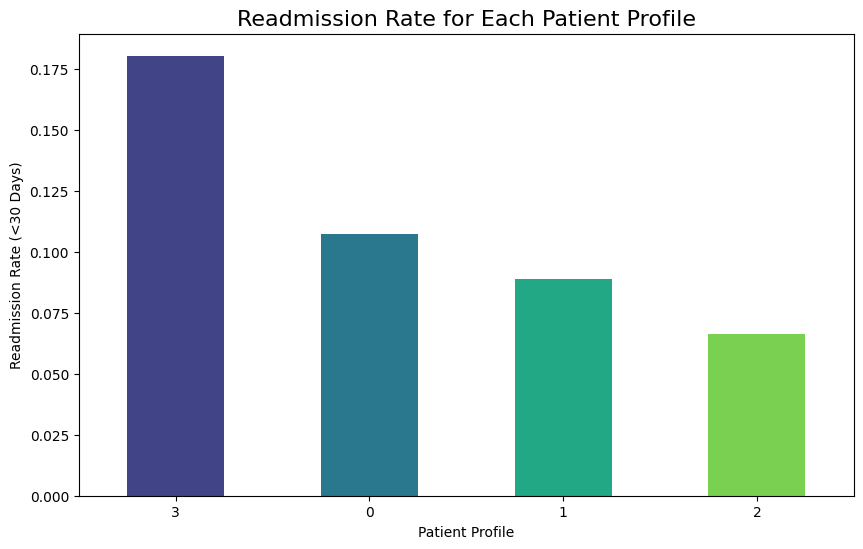

In [ ]:
# Connect the unsupervised profiles to the supervised outcome
readmission_rate_by_profile = df.groupby('patient_profile')['readmitted'].mean().sort_values(ascending=False)

# Visualize the readmission rate by profile
plt.figure(figsize=(10, 6))
readmission_rate_by_profile.plot(kind='bar', color=sns.color_palette('viridis', k))
plt.title('Readmission Rate for Each Patient Profile', fontsize=16)
plt.xlabel('Patient Profile')
plt.ylabel('Readmission Rate (<30 Days)')
plt.xticks(rotation=0)
# plt.savefig("readmission_by_profile.png")
plt.show()

Normalize the cluster feature averages using z-score, then plot radar charts to visualize the feature patterns of each profile. Radar charts provide a holistic view of how each cluster differs across all features.

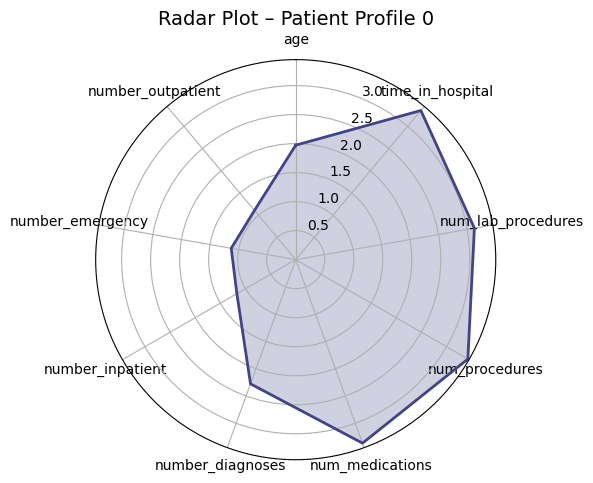

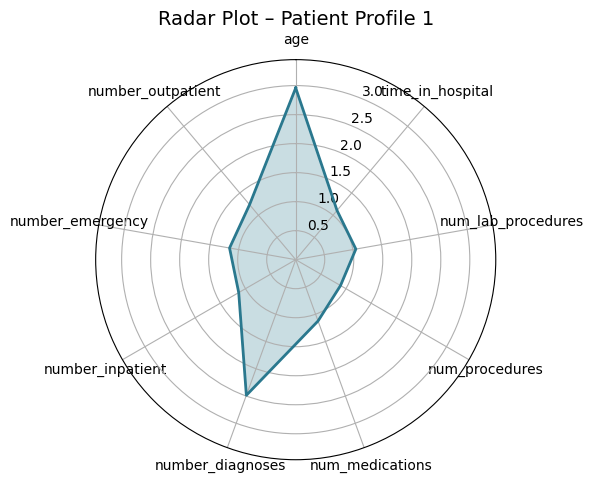

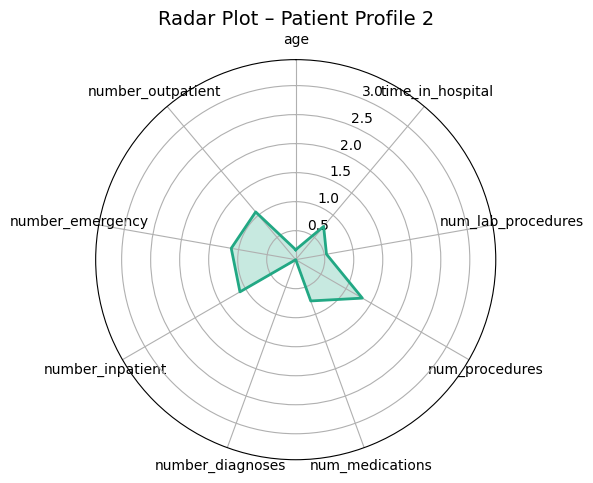

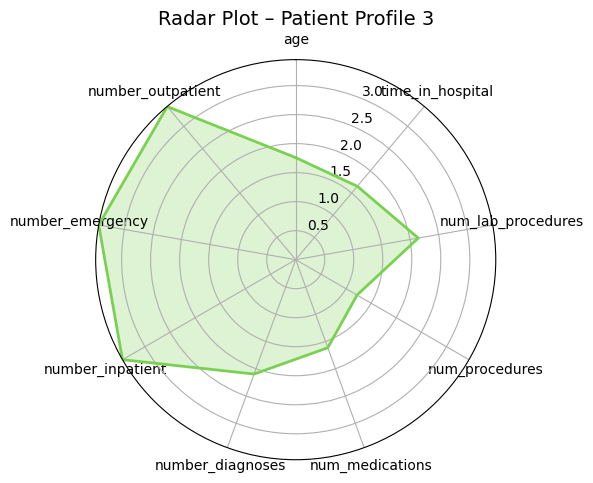

In [ ]:
# Normalize the profile summary for visualization using z-score normalization
from scipy.stats import zscore

profile_zscore = profile_summary.apply(zscore)

# Shift all values to be non-negative for radar plot (min=0)
profile_zscore_shifted = profile_zscore - profile_zscore.min().min()


# Get feature labels and angle setup
labels = profile_zscore_shifted.columns.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

colors = sns.color_palette('viridis', n_colors=len(profile_zscore_shifted))

# Plot each cluster in a separate radar chart
for i, (profile_id, row) in enumerate(profile_zscore_shifted.iterrows()):
    values = row.tolist()
    values += values[:1]  # close the loop
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color=colors[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.25)
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(f'Radar Plot – Patient Profile {profile_id}', fontsize=14)
    ax.set_ylim(0, profile_zscore_shifted.values.max())

    plt.tight_layout()
    # plt.savefig(f"radar_profile_{profile_id}.png")
    plt.show()

Normalize the profile summary for heatmap visualization and plot a heatmap to compare feature averages across clusters. This visual summary highlights similarities and differences between patient profiles.

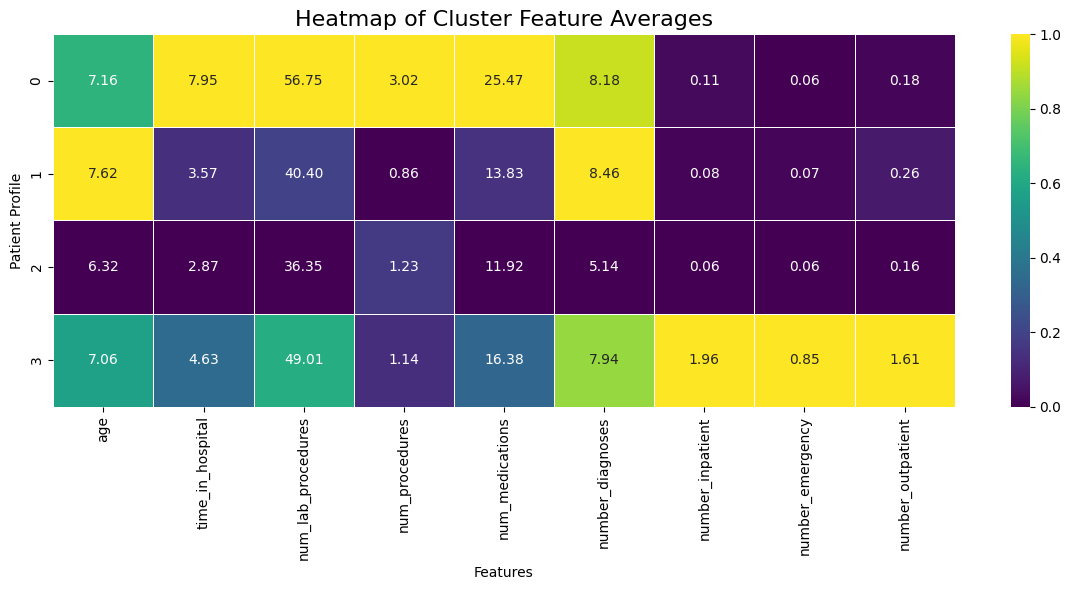

In [ ]:
profile_normalized = (profile_summary - profile_summary.min()) / (profile_summary.max() - profile_summary.min())

plt.figure(figsize=(12, 6))
sns.heatmap(profile_normalized, annot=profile_summary, fmt=".2f", cmap='viridis', linewidths=0.5)
plt.title('Heatmap of Cluster Feature Averages', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Patient Profile')
plt.tight_layout()
# plt.savefig("cluster_heatmap.png")
plt.show()